## Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
import os
%matplotlib inline

In [2]:
# Which downsampling norm to use: This selects input data:
# dd: Deduplicated downsampled data
# aa: Analyse all reads in data, downsample based on number of PF reads
DS_MODE = "aa"

## Alignment notes

Alignment with bwa-mem.

The minimum seed length is 19.

Maximum gap length: 100.

### Load Picard data

#### Step 1 is to load all the metrics from the downsampled data.

In [3]:
def load_picard(path):
    with open(path) as f:
        mode = None
        metrics_header = None
        metrics_data = {}
        histogram_series = []
        histogram_data = []
        for l in f:
            line = l.rstrip("\r\n")
            if mode == 'metrics':
                metrics_header = line.split()
                mode = 'metrics2'
            elif mode == 'metrics2':
                if line != "":
                    metrics_data = dict(zip(metrics_header, line.split()))
                else:
                    mode = None
            elif mode == 'histogram':
                histogram_series = line.split()
                histogram_data = [list() for _ in histogram_series]
                mode = 'histogram2'
            elif mode == 'histogram2':
                if line != "":
                    for i, value in enumerate(line.split()):
                        histogram_data[i].append(value)
                else:
                    mode = None
            elif line.startswith("## METRICS CLASS"):
                mode = 'metrics'
            elif line.startswith("## HISTOGRAM"):
                mode = 'histogram'
        if histogram_series:
            #metrics_data['histograms'] = dict(zip(histogram_series, histogram_data))
            for name, data in zip(histogram_series, histogram_data):
                metrics_data[name] = [float(x) for x in data]
    return metrics_data

In [6]:
samples = []
for bam in glob("30_downsample/*-{}_DS_MD.AlignmentSummaryMetrics.txt".format(DS_MODE)):
    basepath = re.sub(r"_MD\.AlignmentSummaryMetrics\.txt$", "", bam)
    data = {}
    try:
        for metrics in ['_MD.AlignmentSummaryMetrics', '_MD.InsertSizeMetrics',
                        '.MarkDuplicatesMetrics', '_MD.WgsMetrics']:
            new_data = load_picard("{}{}.txt".format(basepath, metrics))
            if any(k in data for k in new_data):
                print("Duplicate key {} found in {}".format(k, metrics))
            data.update(new_data)
    except FileNotFoundError as e:
        print("File {} not found, skipping this sample.".format(e.filename))
        continue
    samples.append(data)

In [7]:
print(len(samples))

40


#### Step 2: Get original number of PF reads from before downsampling.

In [8]:
inital_read_counts = []
for alignment_txt in glob("20_piccard/*.AlignmentSummaryMetrics.txt"):
    library = re.match(r"([^/]+)\.AlignmentSummaryMetrics.txt", os.path.basename(alignment_txt)).group(1)
    new_data = load_picard(alignment_txt)
    inital_read_counts.append({'LIBRARY': library, 'INITIAL_READS': int(new_data['TOTAL_READS']),
                                    'INITIAL_READS_PER_END': int(new_data['TOTAL_READS']) / 2,
                                    'INITIAL_READS_ALIGNED': int(new_data['PF_READS_ALIGNED']),
                                    'INITIAL_READS_ALIGNED_PER_END': int(new_data['PF_READS_ALIGNED']) / 2})

In [9]:
dedup_read_counts = []
for rc_txt in glob("20_piccard_dd/*.readCount.txt"):
    library = re.match(r"([^/]+)\.readCount\.txt", os.path.basename(rc_txt)).group(1)
    rc = int(open(rc_txt).read().strip())
    dedup_read_counts.append({'LIBRARY': library, 'DEDUPLICATED_READS': rc, 'DEDUPLICATED_READS_PER_END': rc/2})

#### Step 3: Get arabidopsis metrics.

In [10]:
arabidopsis_samples = []
for bam in glob("arabidopsis/20_piccard/*.bam"):
    basepath = re.sub(r"\.bam$", "", bam)
    data = {}
    for metrics in ['.AlignmentSummaryMetrics', '.InsertSizeMetrics',
                    '.MarkDuplicatesMetrics', '.WgsMetrics']:
        new_data = load_picard("{}{}.txt".format(basepath, metrics))
        if any(k in data for k in new_data):
            print("Duplicate key {} found in {}".format(k, metrics))
        data.update(new_data)
    arabidopsis_samples.append(data)

In [11]:
print(samples[0]['LIBRARY'])
#print(inital_read_counts[0]['LIBRARY'])
print("TODO. There is no arabidopsis yet.")

Nextera-10ng-1
TODO. There is no arabidopsis yet.


In [12]:
main_df = pd.DataFrame(samples).reindex().convert_objects(convert_numeric=True)
in_reads_df = pd.DataFrame(inital_read_counts)
dd_reads_df = pd.DataFrame(dedup_read_counts)
arabidopsis_df = pd.DataFrame(arabidopsis_samples).convert_objects(convert_numeric=True)


df = pd.merge( 
    pd.merge(
        main_df, 
        in_reads_df,  
        on='LIBRARY').reindex(), 
    dd_reads_df,  
    on='LIBRARY')

# WITH DOPSIS
#df = pd.merge( 
#    pd.merge( 
#        pd.merge( 
#            main_df, 
#            arabidopsis_df, 
#            on='LIBRARY', suffixes=('', '_AR')).reindex(), 
#        in_reads_df,  
#        on='LIBRARY').reindex(), 
#    dd_reads_df,  
#    on='LIBRARY')
df.dtypes[0:10]

/ypool/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/ypool/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


All_Reads.fr_count         object
BAD_CYCLES                  int64
BIN                        object
CATEGORY                   object
ESTIMATED_LIBRARY_SIZE      int64
GENOME_TERRITORY            int64
HET_SNP_Q                   int64
HET_SNP_SENSITIVITY       float64
LIBRARY                    object
MAD_COVERAGE                int64
dtype: object

In [13]:
df['Kit'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(0))
df['Conc'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(1))
df_100 = df.loc[df.Conc == "100ng"]
df.head(n=1)

,All_Reads.fr_count,BAD_CYCLES,BIN,CATEGORY,ESTIMATED_LIBRARY_SIZE,GENOME_TERRITORY,HET_SNP_Q,HET_SNP_SENSITIVITY,LIBRARY,MAD_COVERAGE,...,non_optical_sets,optical_sets,INITIAL_READS,INITIAL_READS_ALIGNED,INITIAL_READS_ALIGNED_PER_END,INITIAL_READS_PER_END,DEDUPLICATED_READS,DEDUPLICATED_READS_PER_END,Kit,Conc
0,"[401.0, 396.0, 744.0, 398.0, 466.0, 608.0, 554...",0,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",PAIR,2138778317,2934876545,9,0.878989,Nextera-10ng-1,2,...,"[83995523.0, 1132112.0, 65611.0, 23835.0, 1216...","[0.0, 1207068.0, 12263.0, 224.0, 44.0, 18.0, 1...",449238456,441568539,220784269.5,224619228.0,434083158,217041579.0,Nextera,10ng


In [14]:
print("Number of entries: ", len(df))

Number of entries:  40


## Number of reads

Number of PE reads (reads per end):

In [15]:
df['TOTAL_READS_PER_END'] = df['TOTAL_READS'] / 2
num_reads_downsampled = df.TOTAL_READS_PER_END.mean()
num_reads_initial = df.INITIAL_READS_PER_END.mean()
num_reads_deduplicated = df.DEDUPLICATED_READS_PER_END.mean()
print("One lane of HiSeqX:       {:9d} (optimistic)".format(400000000))
print("Initial reads (avg):      {:9d}".format(int(num_reads_initial)))
print("Deduplicated reads (avg): {:9d}".format(int(num_reads_deduplicated)))
print("Downsampled reads:        {:9d}".format(int(num_reads_downsampled)))

One lane of HiSeqX:       400000000 (optimistic)
Initial reads (avg):      198559655
Deduplicated reads (avg): 187794457
Downsampled reads:         89999584


Experiment set-up:

One pool for each kit. There are 8 libraries in each pool. The pool is sequenced on four lanes. Each library gets a half lane's worth of reads on average.

The mean read count per library is around half of the expected 200M, because of less than optimal yield, and inevitable differences between samples in the pool.

The "downsampled" in the table above depends on the constant set at the top of this notebook. It is either based on the lowest Initial reads (aa) or the lowest Deduplicated reads (dd).

In [16]:
print(DS_MODE)

aa


Downsampling is based on the following read counts: aa=INITIAL, dd=DEDUPLICATED.

The point with the fewest reads represents the value used for downsampling (after rounding down).

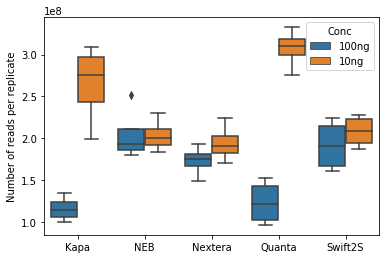

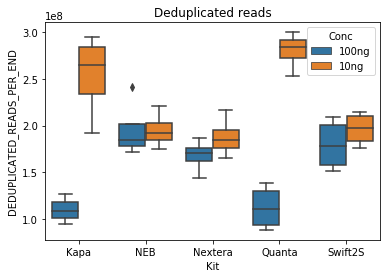

Text(0.5,1,'Downsampled reads')

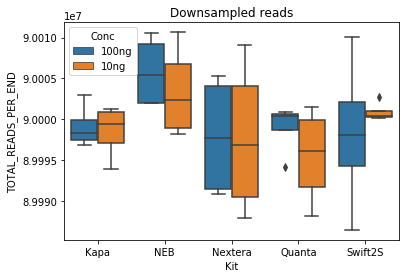

In [18]:
sns.boxplot(data=df, x='Kit', y='INITIAL_READS_PER_END', hue='Conc')
plt.ylabel('Number of reads per replicate')
plt.xlabel("")
plt.savefig("plots/total_number_of_reads.pdf")
plt.show()
sns.boxplot(data=df, x='Kit', y='DEDUPLICATED_READS_PER_END', hue='Conc')
plt.title('Deduplicated reads')
plt.show()
sns.boxplot(data=df, x='Kit', y='TOTAL_READS_PER_END', hue='Conc')
plt.title('Downsampled reads')

## Aligned reads


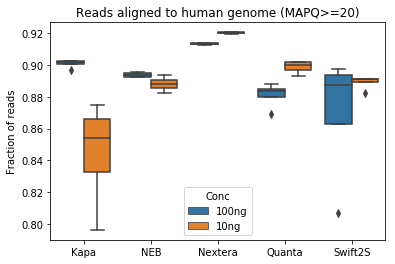

In [20]:
df['PCT_HQ_PF_READS_ALIGNED'] = df.PF_HQ_ALIGNED_READS / df.TOTAL_READS
sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED', hue='Conc')
plt.title('Reads aligned to human genome (MAPQ>=20)')
plt.ylabel("Fraction of reads")
plt.xlabel("")
plt.savefig("plots/aligned_reads_human.pdf")

In [21]:
print("Low aligned rate")
df[df.PCT_HQ_PF_READS_ALIGNED < 0.88][["LIBRARY", "PCT_HQ_PF_READS_ALIGNED"]]

Low aligned rate


,LIBRARY,PCT_HQ_PF_READS_ALIGNED
7,Kapa-10ng-4,0.862983
9,Swift2S-100ng-2,0.806933
21,Kapa-10ng-1,0.844976
34,Kapa-10ng-3,0.796385
37,Kapa-10ng-2,0.874893
39,Quanta-100ng-3,0.869327


In [22]:
# Correct the aligned pct. All reads in the AR dataset are aligned.
df['PCT_HQ_PF_READS_ALIGNED_AR'] = df.PF_HQ_ALIGNED_READS_AR / df.INITIAL_READS
sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED_AR', hue='Conc')
plt.title('Reads aligned to Arabidopsis Lyrata genome (MAPQ >= 20)')
plt.ylabel("Fraction of reads")
plt.xlabel("")
plt.savefig("plots/aligned_reads_arabidopsis.pdf")

AttributeError: 'DataFrame' object has no attribute 'PF_HQ_ALIGNED_READS_AR'

In [23]:
sample = df[df['LIBRARY'] == 'NEB-10ng-1'].iloc[0]
print("sample:", sample.LIBRARY)
print("initial read:", sample.INITIAL_READS)
print("initial (pre-DS) reads aligned to human genome: {} ({:.1f} %)".format(
      sample.INITIAL_READS_ALIGNED, (sample.INITIAL_READS_ALIGNED * 100 / sample.INITIAL_READS)))
print("reads aligned to arabidopsis genome: {} ({:.1f} %)".format(
        sample.PF_READS_ALIGNED_AR, (sample.PF_READS_ALIGNED_AR * 100 / sample.INITIAL_READS)) )
FLAG_2_NREADS_NEB_10ng_1 = 89977265# Filtered on SAM flag 2
assert sample.LIBRARY == "NEB-10ng-1"
print("reads aligned PROPER PAIR to arabidopsis: {} ({:.1f} %)".format(
        FLAG_2_NREADS_NEB_10ng_1, (FLAG_2_NREADS_NEB_10ng_1 * 100 /sample.INITIAL_READS)) )


sample: NEB-10ng-1
initial read: 366035932
initial (pre-DS) reads aligned to human genome: 357632908 (97.7 %)


AttributeError: 'Series' object has no attribute 'PF_READS_ALIGNED_AR'

## Insert size (Picard)

In [24]:
colours = sns.color_palette()
kits = df.Kit.cat.categories
KIT_COL = dict(zip(kits, colours))
print(KIT_COL)

{'Kapa': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'NEB': (1.0, 0.4980392156862745, 0.054901960784313725), 'Nextera': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'Quanta': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'Swift2S': (0.5803921568627451, 0.403921568627451, 0.7411764705882353)}


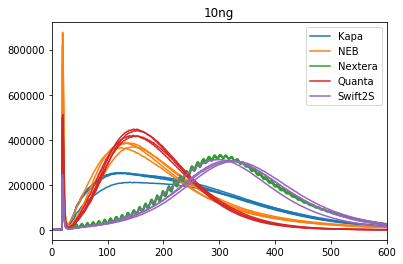

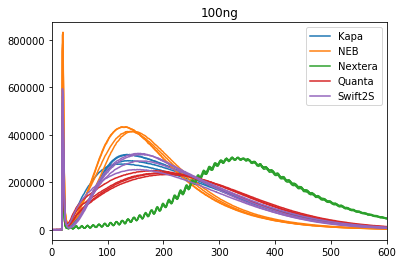

In [25]:
mean_insert_sizes = []
for conc in ["10ng", "100ng"]:
    legends = set()
    plt.figure()
    plt.xlim(0, 600)
    plt.title(conc)
    for kit, group in df[df.Conc==conc].groupby(("Kit"), as_index=False):
        colour = KIT_COL[kit]
        means = []
        for ix, (xs, ys) in group[['insert_size', 'All_Reads.fr_count']].iterrows():
            if not kit in legends:
                plt.plot(xs, ys, color=colour, label=kit)
                legends.add(kit)
            else:
                plt.plot(xs, ys, color=colour)
            # Mean
            values = np.array(xs)
            weights = np.array(ys)
            means.append(sum(weights*values) / sum(weights))
        mean_insert_sizes.append((conc, kit, sum(means) / len(means)))
            
    plt.legend()
    plt.savefig("plots/insert_size_{}.pdf".format(conc))


In [26]:
for vvv in mean_insert_sizes:
    print(*vvv, sep="\t")

10ng	Kapa	240.37577007672678
10ng	NEB	206.29597875568518
10ng	Nextera	325.69439176603976
10ng	Quanta	185.64309429497627
10ng	Swift2S	330.023012703364
100ng	Kapa	227.6172505011575
100ng	NEB	188.4679381532349
100ng	Nextera	366.03950116954775
100ng	Quanta	244.03309622459943
100ng	Swift2S	225.8970094550177


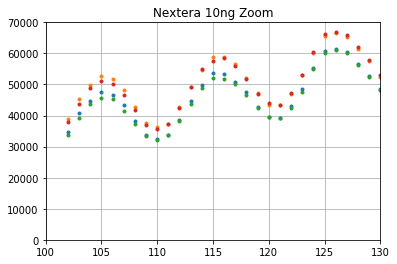

In [63]:
nextera10_samples = df[(df.Conc=="10ng") & (df.Kit=="Nextera")]
plt.figure()
plt.xlim(100, 130)
plt.ylim(0, 70000)
plt.title("Nextera 10ng Zoom")
nextera10_samples[['insert_size', 'All_Reads.fr_count']].apply(
            lambda x: plt.plot(*x.apply(lambda x: x[100:130]), '.'), 
    axis=1)
plt.grid()
plt.savefig("plots/nextera_insert_size.pdf")

0     [Line2D(_line0)]
14    [Line2D(_line1)]
18    [Line2D(_line2)]
26    [Line2D(_line3)]
dtype: object

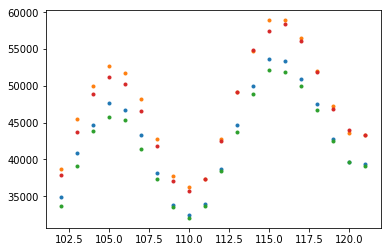

In [59]:
nextera10_samples[['insert_size', 'All_Reads.fr_count']].apply(
            lambda x: plt.plot(*x.apply(lambda x: x[100:120]), '.'), 
    axis=1)

## Short fragments

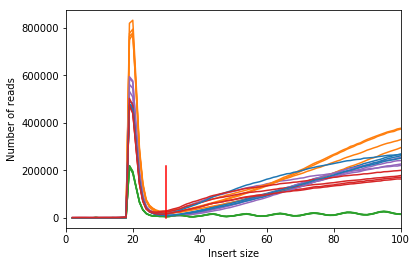

In [27]:
SHORT_FRAG = 28
for i, row in df_100.iterrows():
    col = KIT_COL[row.Kit]
    plt.plot(row['insert_size'], row['All_Reads.fr_count'], color=col)
plt.plot(
    [df['insert_size'][0][SHORT_FRAG], df['insert_size'][0][SHORT_FRAG]],
    [0, max(df['All_Reads.fr_count'][0][0:SHORT_FRAG])],
    'r'
    )
plt.xlim(0, 100)
plt.xlabel("Insert size")
plt.ylabel("Number of reads")
plt.savefig("plots/short_insert_zoom_100ng.pdf")

In [28]:
df['short_fragments_frac'] = df['All_Reads.fr_count'].map(lambda x: sum(x[0:SHORT_FRAG]) / sum(x))

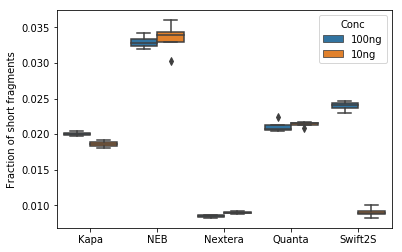

In [66]:
sns.boxplot(data=df, x='Kit', y='short_fragments_frac', hue='Conc')
plt.ylabel("Fraction of short fragments")
plt.xlabel("")
plt.savefig("plots/short_fragments_fraction.pdf")

The peak at short fragment lengths looks serious, but only accounts for max. 4 % of the reads. NEB has more such reads.

## Duplicated reads

This plot shows library duplication rate. The optical duplicates are also counted if the dataset mode is "aa" (analyse all).

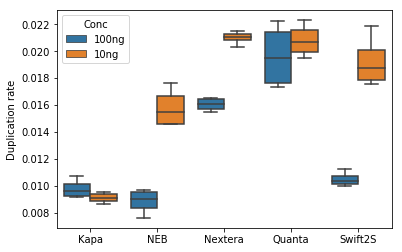

In [67]:
df['PERCENT_DUPLICATION_NON_OPTICAL'] = (
        (df.READ_PAIR_DUPLICATES - df.READ_PAIR_OPTICAL_DUPLICATES)*2 + df.UNPAIRED_READ_DUPLICATES
        ) / (
        df.READ_PAIRS_EXAMINED*2 + df.UNPAIRED_READS_EXAMINED
        )
sns.boxplot(data=df, x='Kit', y='PERCENT_DUPLICATION_NON_OPTICAL', hue='Conc')
#plt.title("Non-optical duplicates")
plt.ylabel("Duplication rate")
plt.xlabel("")
plt.savefig("plots/non_optical_duplicates.pdf")

## Genome coverage

Reference scale for coverage: HiSeqX single lane sequencing.

The PF reads spec for HiSeqX is 2.6 to 3.0 billion per flow cell, so 2.6 B should also provide a 30X genome.

In [68]:
print("*All quantities below in Million reads*")
reads_for_30x = 2.6 * 1000 / 8
print("PF reads per lane for 30X coverage, per end:", reads_for_30x)
expected_per_library_reads = (reads_for_30x * 4) / 8
print("Expected reads per library, 8 libraries over 4 lanes:", expected_per_library_reads)
actual_reads = df.TOTAL_READS.mean() // (2*1000000) # Divide by two, as TOTAL_READS counts both PE ends
print("Actual downsampled read count:", actual_reads)
expected_coverage_level = 30 * (actual_reads / reads_for_30x)
print("")
print("Expected coverage level based on read count:", expected_coverage_level)
print("")

*All quantities below in Million reads*
PF reads per lane for 30X coverage, per end: 325.0
Expected reads per library, 8 libraries over 4 lanes: 162.5
Actual downsampled read count: 89.0

Expected coverage level based on read count: 8.215384615384615



In [69]:
plot_max_cov = 16

In [70]:
test_sample = df.loc[1]

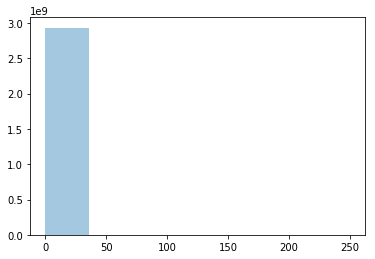

In [71]:
sns.distplot(test_sample['coverage'], kde=False,
             hist_kws={"weights":test_sample['high_quality_coverage_count']})

(0, 16)

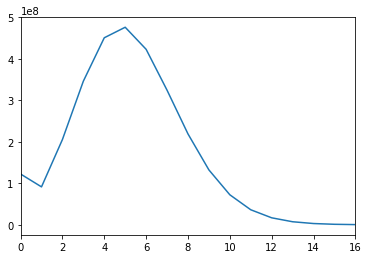

In [72]:
plt.plot(test_sample['coverage'], test_sample['high_quality_coverage_count'])
plt.xlim(0, plot_max_cov)

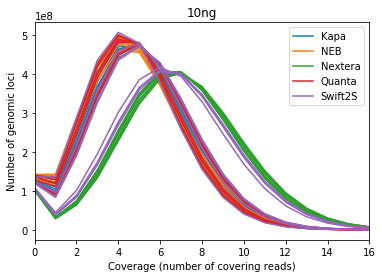

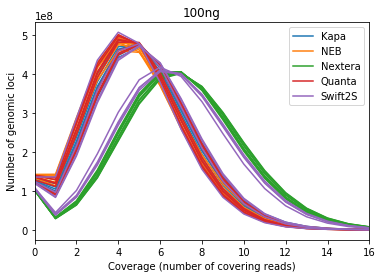

In [73]:

for conc in ["10ng", "100ng"]:
    legends = set()
    plt.xlim(0, plot_max_cov)
    plt.title(conc)
    plt.ylabel("Number of genomic loci")
    plt.xlabel("Coverage (number of covering reads)")

    for kit, group in df.groupby("Kit", as_index=False):
        colour = KIT_COL[kit]
        for ix, (xs, ys) in group[['coverage', 'high_quality_coverage_count']].iterrows():
            if not kit in legends:
                plt.plot(xs, ys, color=colour, label=kit)
            else:
                plt.plot(xs, ys, color=colour)
            legends.add(kit)
    plt.legend()
    plt.savefig("plots/coverage_{}.pdf".format(conc))
    plt.show()

Number of entries, reads

In [74]:
for ix, sample in df.iterrows():
    hist_sum = sum(sample['high_quality_coverage_count'])
    hist_weighted_sum = sum(c * n for c, n in zip(sample['coverage'], 
                                                  sample['high_quality_coverage_count']))
    print(sample['LIBRARY'], "\t:\t", hist_sum, "\t / ", hist_weighted_sum)

NUM_GENOMIC_LOC = hist_sum

Kapa-100ng-1 	:	 2934876545.0 	 /  15197586665.0
Kapa-100ng-2 	:	 2934876545.0 	 /  15159070385.0
Kapa-100ng-3 	:	 2934876545.0 	 /  14797544192.0
Kapa-100ng-4 	:	 2934876545.0 	 /  15183477547.0
Kapa-10ng-1 	:	 2934876545.0 	 /  14522108104.0
Kapa-10ng-2 	:	 2934876545.0 	 /  15300866092.0
Kapa-10ng-3 	:	 2934876545.0 	 /  14188138698.0
Kapa-10ng-4 	:	 2934876545.0 	 /  14752842533.0
NEB-100ng-1 	:	 2934876545.0 	 /  13659061660.0
NEB-100ng-2 	:	 2934876545.0 	 /  13776478534.0
NEB-100ng-3 	:	 2934876545.0 	 /  14274433368.0
NEB-100ng-4 	:	 2934876545.0 	 /  13512662434.0
NEB-10ng-1 	:	 2934876545.0 	 /  14487512631.0
NEB-10ng-2 	:	 2934876545.0 	 /  13800094802.0
NEB-10ng-3 	:	 2934876545.0 	 /  14221737633.0
NEB-10ng-4 	:	 2934876545.0 	 /  13606651698.0
Nextera-100ng-1 	:	 2934876545.0 	 /  20819509558.0
Nextera-100ng-2 	:	 2934876545.0 	 /  20750275969.0
Nextera-100ng-3 	:	 2934876545.0 	 /  20505494456.0
Nextera-100ng-4 	:	 2934876545.0 	 /  20569924081.0
Nextera-10ng-1 	:	 29348

## Cumulative coverage

In [75]:
df['cumulative_num_reads'] = df.high_quality_coverage_count.apply(np.cumsum)
df['cumulative_frac_reads'] = df.cumulative_num_reads.apply(lambda x: x / NUM_GENOMIC_LOC)

In [76]:
df.cumulative_num_reads.loc[3][-1] # Number of genomic loci

2934876545.0

C:\Users\mariu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  del sys.path[0]


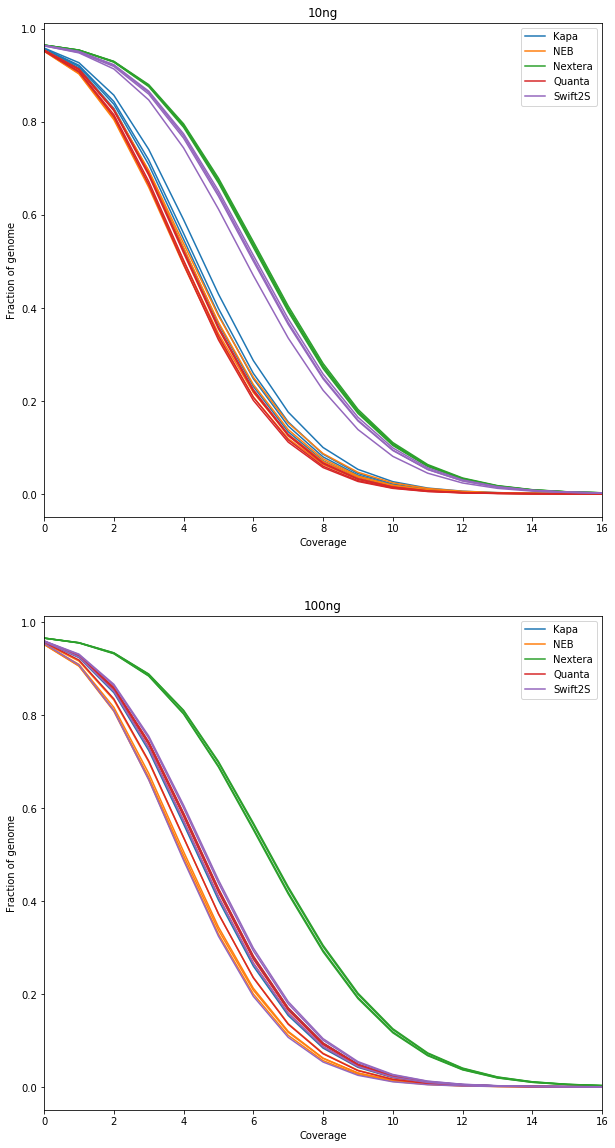

In [77]:
legends = set()

fig = plt.figure(figsize=(10, 20))
axs = {
    "10ng": fig.add_subplot(2, 1, 1),
    "100ng": fig.add_subplot(2, 1, 2)
}
for conc, ax in axs.items():
    ax.set_xlim(0, plot_max_cov)
    ax.set_title(conc)
    ax.set_ylabel("Fraction of genome")
    ax.set_xlabel("Coverage")
for (kit, conc), group in df.groupby(("Kit", "Conc"), as_index=False):
    colour = KIT_COL[kit]
    ax = axs[conc]
    for ix, (xs, yys) in group[['coverage', 'cumulative_frac_reads']].iterrows():
        ys = 1.0 - yys
        if not (ax, kit) in legends:
            ax.plot(xs, ys, color=colour, label=kit)
        else:
            ax.plot(xs, ys, color=colour)
        legends.add((ax, kit))
for ax in axs.values():
    ax.legend()

Text(0.5, 0, 'Coverage')

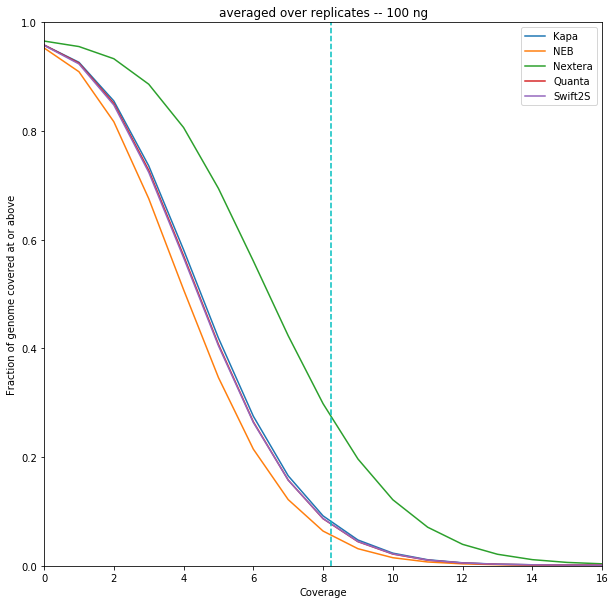

In [78]:
fig = plt.figure(figsize=(10, 10))


for kit, group in df[df.Conc=='100ng'].groupby("Kit", as_index=False):
    ys = 1.0 - np.mean(group['cumulative_frac_reads'])
    xs = group['coverage'].iloc[0]
    plt.plot(xs, ys, color=KIT_COL[kit], label=kit)

plt.legend()
plt.plot([expected_coverage_level, expected_coverage_level], [0.0,1.0], 'c--')
plt.xlim(0, plot_max_cov)
plt.ylim(0, 1)
plt.title("averaged over replicates -- 100 ng")
plt.ylabel("Fraction of genome covered at or above")
plt.xlabel("Coverage")


In [79]:
#list(df)

In [80]:
table = df_100.groupby('Kit')[
    ['MEAN_COVERAGE','MEDIAN_COVERAGE', 'PCT_1X',
     'PCT_10X', 'TOTAL_READS', 'INITIAL_READS']
    ].mean()
table

,MEAN_COVERAGE,MEDIAN_COVERAGE,PCT_1X,PCT_10X,TOTAL_READS,INITIAL_READS
Kit,,,,,,
Kapa,5.139712,5.00,0.957992,0.047469,179998242.0,231552363.5
NEB,4.704000,4.50,0.952627,0.031436,180011693.5,408351261.5
Nextera,7.039922,7.00,0.965307,0.196492,179995698.5,346128359.0
Quanta,5.073272,5.00,0.958027,0.044357,179997947.5,246424318.0
Swift2S,5.058357,4.75,0.957373,0.044794,179996364.0,382962926.5


The analysis was first done with a different reference, including ALTernative contigs. It's probably not a good idea to use these ALT contigs unless the whole pipeline takes them into account all the time.

Kit,MEAN_COVERAGE,MEDIAN_COVERAGE,PCT_1X,PCT_10X,TOTAL_READS
Kapa,4.84100525,5.0,0.90678325,0.044468,179998242.0
NEB,4.42826475,4.25,0.9013639999999999,0.0293165,180011693.5
Nextera,6.6390705,7.0,0.9147957499999999,0.1851845,179995698.5
Quanta,4.7782167499999995,5.0,0.9069119999999999,0.041523500000000005,179997947.5
Swift2S,4.76407625,4.75,0.9061827499999999,0.041947250000000005,179996364.0


In [39]:
#table.to_csv("")

In [40]:
print(df['coverage'][0][0])
print(df['high_quality_coverage_count'][0][0])

0.0
139631546.0


Note on interpretation of coverage histogram: 

In [81]:
# Aligned reads more detailed, todo
read_counts = []

for i, row in df.iterrows():
    library = {
        'LIBRARY': row.LIBRARY,
        'Kit': row.Kit,
        'Conc': row.Conc
    }
    read_counts.append(dict(
                        Reads=row.TOTAL_READS_PER_END,
                        Type='Downsampled',
                        **library))
    aligned = 1